# SPECFEM Users Workshop -- Day 1 (Oct. 5, 2022)
## Day 1B: Forward Simulations

- Here we build upon material learned in Day 1A  
- This notebook allows Users to play around with their own SPECFEM2D homogeneous halfspace example in an exercise  
- **Objective:** Familiarize Users with setting `SOURCE` and `STATION` attributes, adjusting velocity model parameters, and assessing simulation results.
- These instructions should be run from inside the Docker container, using Jupyter Lab (see *Docker Preamble* in Day 0)  

-----------

**Relevant Links:** 
- Today's Notebook: https://github.com/adjtomo/adjdocs/blob/main/workshops/2022-10-05_specfem_users/day_1b_forward_simulations.ipynb
- Completed Notebook https://github.com/adjtomo/adjdocs/blob/main/workshops/2022-10-05_specfem_users/completed_notebooks/day_1b_forward_simulations.ipynb)
- Day 0 Notebook (Container Testing): https://github.com/adjtomo/adjdocs/blob/main/workshops/2022-10-05_specfem_users/day_0_container_testing.ipynb

**Jupyter Quick Tips:**

- **Run cells** one-by-one by hitting the $\blacktriangleright$ button at the top, or by hitting `Shift + Enter`
- **Run all cells** by hitting the $\blacktriangleright\blacktriangleright$ button at the top, or by running `Run -> Run All Cells`
- **Currently running cells** that are still processing will have a `[*]` symbol next to them
- **Finished cells** will have a `[1]` symbol next to them. The number inside the brackets represents what order this cell has been run in.
- Commands that start with `!` are Bash commands (i.e., commands you would run from the terminal)
- Commands that start with `%` are Jupyter Magic commands.
- To time a task, put a `%time` before the command (e.g., `%time ! ls`)


------
## 1) Set Up a SPECFEM Working Directory

- It is often desireable to run SPECFEM outside of the cloned repository, in order to keep files and outputs manageable  
- The trick here is that SPECFEM **only** requires 3 compenents for a sucessful simulation: `bin/`, `DATA/`, and `OUTPUT_FILES/`  

In [1]:
# Python packages required for this notebook
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

In [2]:
# Create the correct dir. and move there
! mkdir -p /home/scoped/work/day_1/specfem2d_workdir
%cd /home/scoped/work/day_1/specfem2d_workdir

# Symlink the executables, copy example DATA/, create empty OUTPUT_FILES
! ln -s /home/scoped/specfem2d/bin .
! cp -r /home/scoped/specfem2d/EXAMPLES/Tape2007/DATA .
! mkdir OUTPUT_FILES

! ls

/home/scoped/work/day_1/specfem2d_workdir
bin  DATA  OUTPUT_FILES


----------
## 2) Experimental Setup: Tape et al. 2007 Example Problem

- We will be working with an Example problem from the [Tape et al. 2007 GJI publication](https://academic.oup.com/gji/article/168/3/1105/929373)
- [GitHub repository location of the example problem](https://github.com/geodynamics/specfem2d/tree/devel/EXAMPLES/Tape2007)
- This example pre-defines two models (homogeneous halfspace, checkerboard), multiple (25) seismic sources, and multiple (132) stations  
- In this section we will use the homogeneous halfspace model  


In [3]:
! ls DATA/

interfaces_Tape2007.dat		  SOURCE_005  SOURCE_013  SOURCE_021
model_velocity.dat_checker	  SOURCE_006  SOURCE_014  SOURCE_022
Par_file_Tape2007_132rec_checker  SOURCE_007  SOURCE_015  SOURCE_023
Par_file_Tape2007_onerec	  SOURCE_008  SOURCE_016  SOURCE_024
SOURCE_001			  SOURCE_009  SOURCE_017  SOURCE_025
SOURCE_002			  SOURCE_010  SOURCE_018  STATIONS_checker
SOURCE_003			  SOURCE_011  SOURCE_019
SOURCE_004			  SOURCE_012  SOURCE_020


#### DATA/ Directory
- `Par_file` for a homogeneous halfspace model in `Par_file_Tape2007_onerec`
- `Par_file` for a checkerboard model in `Par_file_Tape2007_132rec_checker`
- `Mesh` files in: *interfaces_Tape2007.dat* and the `Par_file_*`
- `Model` files in: *model_velocity.dat_checker*
- `Source` files in: the 25 *SOURCE_???* files
- `Stations`: in the *STATIONS_checker* file

### 2a) The Homogeneous Halfspace Model

- The homogeneous halfspace model in this example is defined internally, in the `Par_file`
- A homogeneous halfspace defines single set of properties for the entire domain  
- We can also use the utility `seisflows sempar velocity_model` command to look at model values  

In [4]:
# Bash commands to look at the Par_file
! head -262 DATA/Par_file_Tape2007_onerec | tail -31
! echo "..."

# SeisFlows utility function to look at the Par_file
! seisflows sempar -P DATA/Par_file_Tape2007_onerec velocity_model

#-----------------------------------------------------------
#
# Velocity and density models
#
#-----------------------------------------------------------

# number of model materials
nbmodels                        = 1
# available material types (see user manual for more information)
#   acoustic:              model_number 1 rho Vp 0  0 0 QKappa 9999 0 0 0 0 0 0 (for QKappa use 9999 to ignore it)
#   elastic:               model_number 1 rho Vp Vs 0 0 QKappa Qmu  0 0 0 0 0 0 (for QKappa and Qmu use 9999 to ignore them)
#   anisotropic:           model_number 2 rho c11 c13 c15 c33 c35 c55 c12 c23 c25   0 QKappa Qmu
#   anisotropic in AXISYM: model_number 2 rho c11 c13 c15 c33 c35 c55 c12 c23 c25 c22 QKappa Qmu
#   poroelastic:           model_number 3 rhos rhof phi c kxx kxz kzz Ks Kf Kfr etaf mufr Qmu
#   tomo:                  model_number -1 0 0 A 0 0 0 0 0 0 0 0 0 0
#
# note: When viscoelasticity or viscoacousticity is turned on,
#       the Vp and Vs values that are read here are

#### Understanding the Velocity Model 
According to the `Par_file` comments, the model parameter values represent the following:  

```bash
model_number 1 rho Vp Vs 0 0 QKappa Qmu  0 0 0 0 0 0
1 1 2600.d0 5800.d0 3500.0d0 0 0 10.d0 10.d0 0 0 0 0 0 0
```

- The homogeneous halfspace model defines a region with P-wave velocity $V_p=5.8$km/s and S-wave velocity $V_s=3.5$km/s.
- The halfspace is also defined by density and attenuation
- We can understand the structure of the mesh by looking at the `Par_file` and the `interfaces_Tape2007.dat` file. 

In [5]:
# Look at Mesh parameters to view the size of the domain
! head -305 DATA/Par_file_Tape2007_onerec | tail -n 25

#-----------------------------------------------------------
#
# PARAMETERS FOR INTERNAL MESHING
#
#-----------------------------------------------------------

# file containing interfaces for internal mesh
interfacesfile                  = interfaces_Tape2007.dat

# geometry of the model (origin lower-left corner = 0,0) and mesh description
xmin                            = 0.d0           # abscissa of left side of the model
xmax                            = 480000.d0      # abscissa of right side of the model
nx                              = 40             # number of elements along X

# absorbing boundary parameters (see absorbing_conditions above)
absorbbottom                    = .true.
absorbright                     = .true.
absorbtop                       = .true.
absorbleft                      = .true.

# define the different regions of the model in the (nx,nz) spectral-element mesh
nbregions                       = 1              # then set below the different regions and 

In [6]:
# Look at interface parameters 
! cat DATA/interfaces_Tape2007.dat

# number of interfaces
 2
#
# for each interface below, we give the number of points and then x,z for each point
#
# interface number 1 (bottom of the mesh)
 2
 0.0 0.0
 480000.0 0.0
# interface number 5 (topography, top of the mesh)
 2
 0.0 480000.0
 480000.0 480000.0
#
# for each layer, we give the number of spectral elements in the vertical direction
#
# layer number 1
 40


#### Understanding the Mesh parameters

- From the files above, we can see that the X and Z dimensions of our mesh range from 0 to 480000.0m
- Each dimension is separated into 40 elements (defined by `nxmin`, `nxmax` etc. in the `Par_file` and defined by the layer numbers in the interfaces file)  
- That means each spectral element in our 2D mesh spans: 480000m / 40 elements = 12000m / element  (or 12km / element)
- Also note that above we previously learned that the $V_s$ model has a homogeneous value of 3.5 km/s

#### Visualizing the Model
We can make a simple plot using Matplotlib to illustrate what our mesh might look like

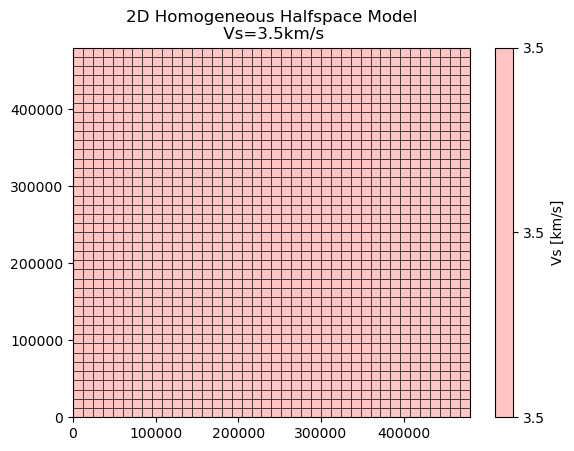

In [7]:
def plot_homogeneous_halfspace():
    """Plots a representation of the SPECFEM2D homogeneous halfspace model"""
    # Sets the X and Z dimensions of our mesh
    x = np.arange(0, 480001, 4000)
    z = np.arange(0, 480001, 4000)
    
    # Reformat the 1D arrays into 2D
    xv, zv = np.meshgrid(x, z)

    # Set a homogeneous value of Vs=3.5km/s 
    vs = 3.5 * np.ones(np.shape(xv))

    # Plot the arrays as a homogeneous halfspace
    plt.tricontourf(xv.flatten(), zv.flatten(), vs.flatten(), cmap="seismic_r", vmin=3.1, vmax=4.)
    plt.colorbar(label="Vs [km/s]", format="%.1f")
    plt.title("2D Homogeneous Halfspace Model\n Vs=3.5km/s")
    
# Calls the function we just defined
plot_homogeneous_halfspace()

# Plot grid lines representing each of the spectral elements
for i in range(12000, 480000, 12000):
    plt.axvline(i, c="k", lw=0.5)
    plt.axhline(i, c="k", lw=0.5)

### 2b) Visualizing Source-Receiver Geometry

- We can similarly plot the SOURCES and STATIONS available to see what the experiemental setup looks like  
- This is the same Python-based approach we took in the Day 1A notebook

Text(0.5, 1.0, 'SOURCE-RECEIVER GEOMETRY')

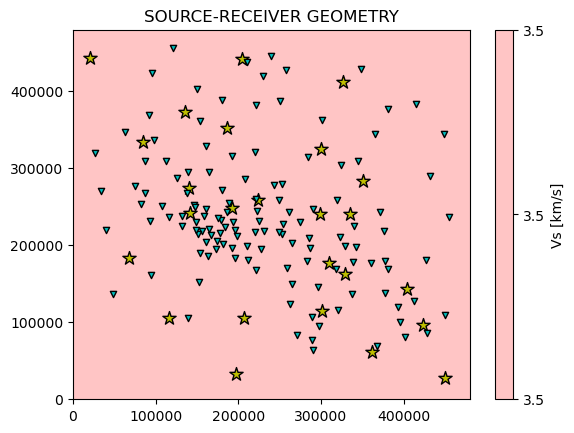

In [8]:
# Grab coordinates from STATIONS file
sta_x, sta_z = np.genfromtxt("DATA/STATIONS_checker", dtype=float, usecols=[2, 3]).T

# Grab coordinates from each SOURCE file
ev_x, ev_z = [], []
for i in range(1, 26):
    source_file = f"DATA/SOURCE_{i:0>3}"
    with open(source_file, "r") as f:
        lines = f.readlines()
    # Trying to break apart the following line
    # 'xs = 299367.72      # source location x in meters\n'
    xs = float(lines[2].split("=")[1].split("#")[0].strip())
    zs = float(lines[3].split("=")[1].split("#")[0].strip())
    
    ev_x.append(xs)
    ev_z.append(zs)
    
# Plot SOURCES and STATIONS together. Annotate names
plot_homogeneous_halfspace()
plt.scatter(ev_x, ev_z, c="y", marker="*", s=100, edgecolor="k")
plt.scatter(sta_x, sta_z, c="c", marker="v", s=20, edgecolor="k")
plt.title("SOURCE-RECEIVER GEOMETRY")

Text(0.5, 1.0, 'SOURCES; N=25')

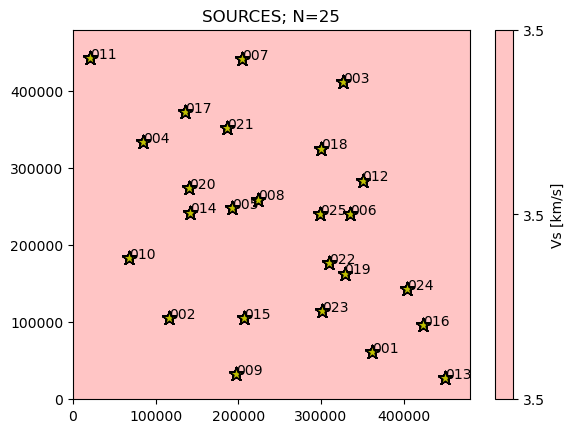

In [9]:
# Plot SOURCES next to source names
plot_homogeneous_halfspace()
for i, (x, z) in enumerate(zip(ev_x, ev_z)):
    plt.scatter(ev_x, ev_z, c="y", marker="*", s=100, edgecolor="k")
    plt.text(x, z, f"{i+1:0>3}")  # SOURCE numbering starts at 1
plt.title(f"SOURCES; N={len(ev_x)}")

Text(0.5, 1.0, 'STATIONS; N=132')

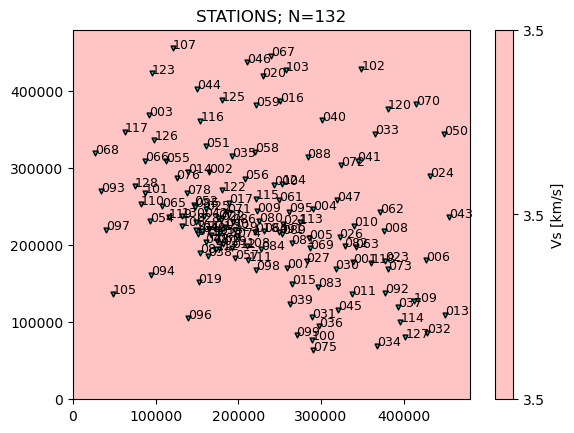

In [10]:
# Plot STATIONS with their names
# Because STATIONS are so close, numbers will be jumbled.
plot_homogeneous_halfspace()
for i, (x, z) in enumerate(zip(sta_x, sta_z)):
    plt.scatter(x, z, c="c", marker="v", s=12, edgecolor="k")
    plt.text(x, z, f"{i:0>3}", fontsize=9)
plt.title(f"STATIONS; N={len(sta_x)}")

- Upside-down blue triangles represent the 132 receivers in this example
- The 25 yellow stars are the sources. 

----------
## 3) Running SPECFEM2D

- Before we run the example, we need to do some organizational bookkeeping  
- We will choose ONE of our source files to act as our source
- We will choose ONE stations to act as our station file  

### 3a) Choosing a Source file

- SPECFEM2D will look for a file named `SOURCE` in the *DATA/* directory to define its source

In [11]:
# Choose SOURCE_001 as our SOURCE File
! cp -f DATA/SOURCE_001 DATA/SOURCE

# > Make sure that the SOURCE name printed below matches choice
! head -1 DATA/SOURCE

## Source 1


### 3b) Choosing Stations

- SPECFEM2D will look for a file named `STATIONS` in the *DATA/* directory to define its stations
- The `STATIONS_checker` file defines 132 different station locations, we only want **one**  
- *Remember*: Individual synthetic seismograms simply extract the simulated wavefield at a location, i.e., computational expense is not tied to the number of stations. 

In [12]:
# Write out a NEW stations file by choosing station numbers
! head -1 DATA/STATIONS_checker > DATA/STATIONS
! cat DATA/STATIONS

S000000 AA 2.43610e+05 2.78904e+05 0.0 0.0


### 3c) Setting up the `Par_file`

- SPECFEM2D will look for a file called `Par_file` in the *DATA/* directory to set its parameters
- We will copy over the `Par_file_Tape2007_onerec` to define our parameter file  
- We need to change a few key parameters in the `Par_file` to run SPECFEM2D with desired behavior    
- We use the `seisflows sempar` command to make the changes but this can be done with a text editor, Bash etc.  

In [13]:
# Copy in the Example parameter file
! cp -f DATA/Par_file_Tape2007_onerec DATA/Par_file

# Set some necessary parameters for later in the Par_file
! seisflows sempar -P DATA/Par_file nproc 4
! seisflows sempar -P DATA/Par_file use_existing_stations .true.

NPROC: 1 -> 4
use_existing_STATIONS: .false. -> .true.


#### Understanding Parameter Changes

`NPROC`: Sets the number of MPI processors to partition the mesh and run the simulation with. This **must** match the value following `-n` in the MPI      
`use_existing_STATIONS`: Use the STATIONS file we created, as opposed to the `Par_file` definition of stations  

### 3d) Run SPECFEM

- Now that we have set the `Par_file`, the `SOURCE` and `STATIONS` file, we are able to run `xmeshfem2D` and `xspecfem2D` to run our forward simulation.
- We use 4 MPI processes to run this homogeneous halfspace simulation
- We expect only **one** synthetic seismogram to be output from this simulation  

In [14]:
# Ensures we're running with a clean OUTPUT directory
! rm -rf OUTPUT_FILES
! mkdir OUTPUT_FILES

! mpirun -n 4 bin/xmeshfem2D > OUTPUT_FILES/output_meshfem.txt
! mpirun -n 4 bin/xspecfem2D > OUTPUT_FILES/output_solver.txt

! tail OUTPUT_FILES/output_solver.txt

 -------------------------------------------------------------------------------
 Program SPECFEM2D: 
 -------------------------------------------------------------------------------
 -------------------------------------------------------------------------------
 Tape-Liu-Tromp (GJI 2007)
 -------------------------------------------------------------------------------
 -------------------------------------------------------------------------------
 D a t e : 04 - 10 - 2022                                 T i m e  : 00:04:07
 -------------------------------------------------------------------------------
 -------------------------------------------------------------------------------


### 3e) Examine Output Files

- Let's confirm that we have created **one** displacement seismogram
- Then we'll look at the forward simulation figures to see if things make sense


In [15]:
! ls OUTPUT_FILES/
! echo
! ls OUTPUT_FILES/*.semd

AA.S000000.BXY.semd	    forward_image000003000.jpg
Database00000.bin	    forward_image000003200.jpg
Database00001.bin	    forward_image000003400.jpg
Database00002.bin	    forward_image000003600.jpg
Database00003.bin	    forward_image000003800.jpg
forward_image000000005.jpg  forward_image000004000.jpg
forward_image000000200.jpg  forward_image000004200.jpg
forward_image000000400.jpg  forward_image000004400.jpg
forward_image000000600.jpg  forward_image000004600.jpg
forward_image000000800.jpg  forward_image000004800.jpg
forward_image000001000.jpg  forward_image000005000.jpg
forward_image000001200.jpg  mesh_materials.vtk
forward_image000001400.jpg  mesh_partition_number.vtk
forward_image000001600.jpg  output_list_stations.txt
forward_image000001800.jpg  output_meshfem.txt
forward_image000002000.jpg  output_solver.txt
forward_image000002200.jpg  plot_points_per_wavelength_histogram.gnu
forward_image000002400.jpg  plot_source_time_function.txt
forward_image000002600.jpg  points_per_wavelength

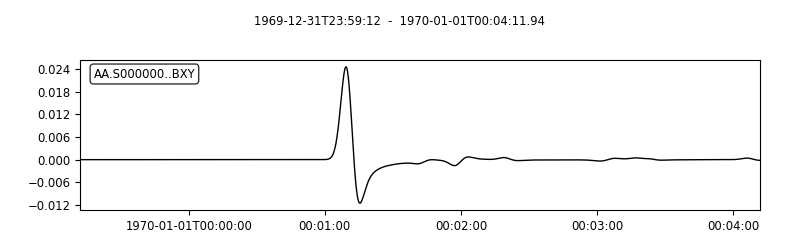

In [16]:
# We can use SeisFlows to plot our waveform
! seisflows plotst OUTPUT_FILES/AA.S000000.BXY.semd --savefig AA.S000000.BXY.png
Image("AA.S000000.BXY.png")

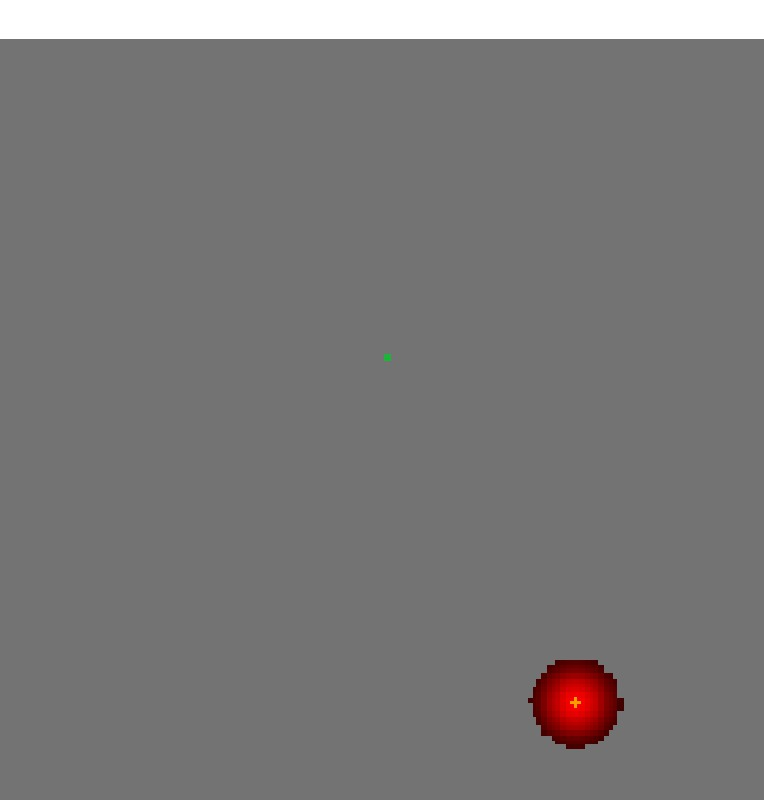

In [17]:
# We can also look at the wavefield snapshots
Image("OUTPUT_FILES/forward_image000000800.jpg")

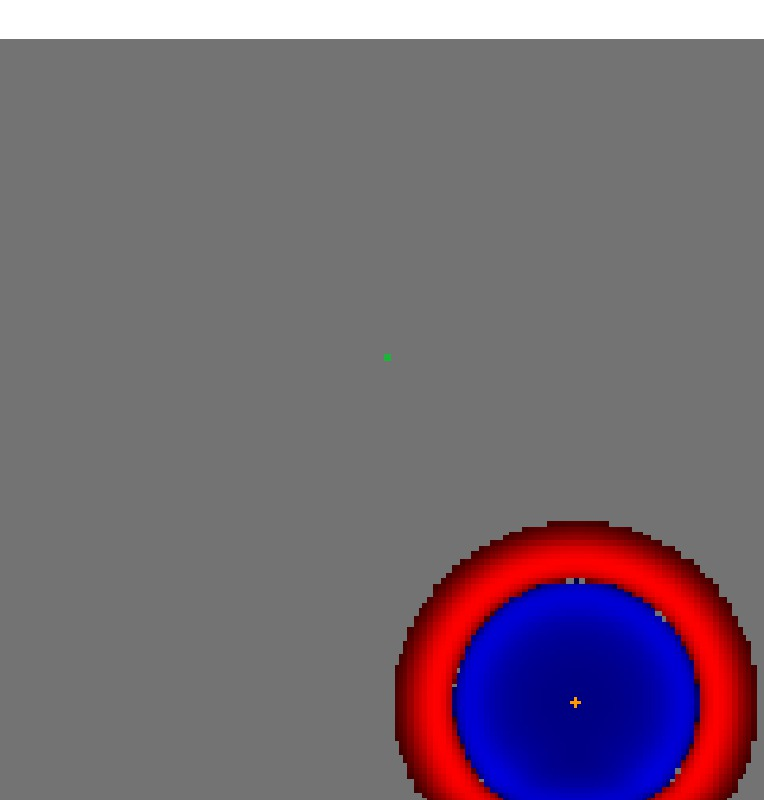

In [18]:
# We can also look at the wavefield snapshots
Image("OUTPUT_FILES/forward_image000001200.jpg")

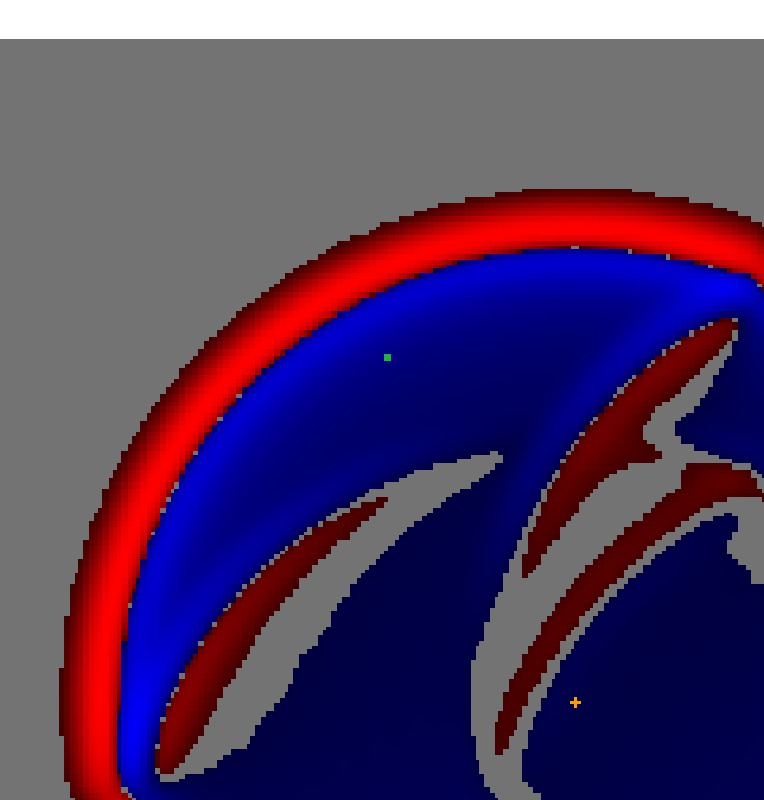

In [19]:
# We can also look at the wavefield snapshots
Image("OUTPUT_FILES/forward_image000002200.jpg")

---------------------
## 4) Forward Simulation Exercise

- Participants will now be asked to edit simulation parameters to run their own simulation  
- Some things that you are asked to try include:
    1) Change the parameters of the homogeneous halfspace model defined in the `Par_file` 
    2) Define a *STATIONS* file with a uniform grid of stations to record synthetics throughout the domain
    3) Choose a different source, or increase the energy released by the source (using the moment tensor)
    4) Re-run the mesher and solver to get new synthetics
    5) Analyze the new results in comparison to the old results
- First we set up a working directory for you  

In [20]:
! rm -rf /home/scoped/work/day_1/exercise
! mkdir -p /home/scoped/work/day_1/exercise
%cd /home/scoped/work/day_1/exercise

# Symlink the executables, copy example DATA/, create empty OUTPUT_FILES
! ln -s /home/scoped/specfem2d/bin .
! cp -r /home/scoped/specfem2d/EXAMPLES/Tape2007/DATA .
! mkdir OUTPUT_FILES

# Set the Par_file
! cp DATA/Par_file_Tape2007_onerec DATA/Par_file

! ls

/home/scoped/work/day_1/exercise
bin  DATA  OUTPUT_FILES


#### Task 1: Edit the Velocity Model
- Change the velocity model parameters in the homogeneous halfspace model
- Remember, the velocity model is defined in the `Par_file`
- Try **increasing** seismic velocity (Vp and Vs) by 10\%
- You can use Python, Bash, `seisflows sempar` or a Text Editor to do this  

In [21]:
# Figure out current values
! seisflows sempar -P DATA/Par_file velocity_model

VELOCITY_MODEL:

1 1 2600.d0 5800.d0 3500.0d0 0 0 10.d0 10.d0 0 0 0 0 0 0


In [22]:
# Values figured out from the Par_file, increased by 10%
vp = 5800. * 1.1
vs = 3500. * 1.1

print(f"vp={vp:.2f}; vs={vs:.2f}")

vp=6380.00; vs=3850.00


In [23]:
# Overwrite the current velocity model with a +10% model
! seisflows sempar -P DATA/Par_file velocity_model "1 1 2600.d0 6380.d0 3850.0d0 0 0 10.d0 10.d0 0 0 0 0 0 0"

VELOCITY_MODEL:

1 1 2600.d0 5800.d0 3500.0d0 0 0 10.d0 10.d0 0 0 0 0 0 0
->
1 1 2600.d0 6380.d0 3850.0d0 0 0 10.d0 10.d0 0 0 0 0 0 0


#### Task 2: Create a New STATIONS File
- Define a STATIONS file that covers the **entire** domain with a uniform grid spacing of: 
    - dx = 80km 
    - dz = 80km
    - x_start = 0km
    - z_start = 0km
- You can find the X and Z dimensions of the mesh in the `Par_file` and the `interfaces` file, respectively  
- Use Python/NumPy to loop values, or simply write out a text file manually with the text editor
- *Look* at *DATA/STATIONS_checker* for an example of how the file should look
- **NOTE**: The last two columns (burial, elevation) can be set to 0  

In [24]:
# Par_file defines the 'X' dimension of the mesh
! head -293 DATA/Par_file | tail -n 3

xmin                            = 0.d0           # abscissa of left side of the model
xmax                            = 480000.d0      # abscissa of right side of the model
nx                              = 40             # number of elements along X


In [25]:
# Interfaces defines the 'Z' dimension of the mesh
! cat DATA/interfaces_Tape2007.dat

# number of interfaces
 2
#
# for each interface below, we give the number of points and then x,z for each point
#
# interface number 1 (bottom of the mesh)
 2
 0.0 0.0
 480000.0 0.0
# interface number 5 (topography, top of the mesh)
 2
 0.0 480000.0
 480000.0 480000.0
#
# for each layer, we give the number of spectral elements in the vertical direction
#
# layer number 1
 40


In [26]:
# Loop through X and Z discretizations of 40km
i = 0
with open("DATA/STATIONS", "w") as f:
    for x in range(0, 480000 + 1, 80000):
        for z in range(0, 480000 + 1, 80000):
            f.write(f"S{i:0>6} AA {x:9.2f} {z:9.2f} 0. 0.\n")
            i += 1
            
! cat DATA/STATIONS

S000000 AA      0.00      0.00 0. 0.
S000001 AA      0.00  80000.00 0. 0.
S000002 AA      0.00 160000.00 0. 0.
S000003 AA      0.00 240000.00 0. 0.
S000004 AA      0.00 320000.00 0. 0.
S000005 AA      0.00 400000.00 0. 0.
S000006 AA      0.00 480000.00 0. 0.
S000007 AA  80000.00      0.00 0. 0.
S000008 AA  80000.00  80000.00 0. 0.
S000009 AA  80000.00 160000.00 0. 0.
S000010 AA  80000.00 240000.00 0. 0.
S000011 AA  80000.00 320000.00 0. 0.
S000012 AA  80000.00 400000.00 0. 0.
S000013 AA  80000.00 480000.00 0. 0.
S000014 AA 160000.00      0.00 0. 0.
S000015 AA 160000.00  80000.00 0. 0.
S000016 AA 160000.00 160000.00 0. 0.
S000017 AA 160000.00 240000.00 0. 0.
S000018 AA 160000.00 320000.00 0. 0.
S000019 AA 160000.00 400000.00 0. 0.
S000020 AA 160000.00 480000.00 0. 0.
S000021 AA 240000.00      0.00 0. 0.
S000022 AA 240000.00  80000.00 0. 0.
S000023 AA 240000.00 160000.00 0. 0.
S000024 AA 240000.00 240000.00 0. 0.
S000025 AA 240000.00 320000.00 0. 0.
S000026 AA 240000.00 400000.00 0. 0.
S

#### Task 3: Choose and edit a SOURCE file

- Use one of the original sources as a template for your new source
- **Set** the location of your source in the exact **middle** of your domain  
- **Set** the moment tensor (Mxx, Mzz, Mxz) of your event to make this an **explosive** source
- Don't change the scaling on the moment tensor  

In [27]:
# 008 is roughly middle. Figure out what the current moment tensor components are
! cp DATA/SOURCE_008 DATA/SOURCE
! head -51 DATA/SOURCE | tail -n 3

Mxx                             = 1.000000       # Mxx component (for a moment tensor source only)
Mzz                             = -1.000000      # Mzz component (for a moment tensor source only)
Mxz                             = 0.000000       # Mxz component (for a moment tensor source only)


In [28]:
lines = open("DATA/SOURCE", "r").readlines()
for i, line in enumerate(lines):
    if "xs" in line:
        lines[i] = "xs = 240000\n"
    elif "zs" in line: 
        lines[i] = "zs = 240000\n"
    else:
        for value in ["Mxx", "Mzz", "Mxz"]:
            if value in line:
                lines[i] = f"{value} = 1.0\n"

with open("DATA/SOURCE", "w") as f:
    f.writelines(lines)
    
# Check the file
! head -5 DATA/SOURCE
! echo
! head -51 DATA/SOURCE | tail -n 3

## Source 1
source_surf                     = .false.        # source inside the medium, or source automatically moved exactly at the surface by the solver
xs = 240000
zs = 240000
## Source type parameters:

Mxx = 1.0
Mzz = 1.0
Mxz = 1.0


#### Task 4: Run the Solver and Analyze Outputs

- Run the mesher and solver with your new experimental setup and 4 MPI processes  
- **Remember** to tell SPECFEM to use your `STATIONS` file and not its internal representation of stations
- **Remember** to tell SPECFEM that we want to run this with 4 processors
- Look at the source images to see if your explosion makes sense
- Plot waveforms output from your gridded stations

In [29]:
! seisflows sempar -P DATA/Par_file nproc 4
! seisflows sempar -P DATA/Par_file use_existing_stations .true.

! mpirun -n 4 bin/xmeshfem2D > OUTPUT_FILES/output_mesher.txt
! mpirun -n 4 bin/xspecfem2D > OUTPUT_FILES/output_solver.txt

! tail OUTPUT_FILES/output_solver.txt

NPROC: 1 -> 4
use_existing_STATIONS: .false. -> .true.
 -------------------------------------------------------------------------------
 Program SPECFEM2D: 
 -------------------------------------------------------------------------------
 -------------------------------------------------------------------------------
 Tape-Liu-Tromp (GJI 2007)
 -------------------------------------------------------------------------------
 -------------------------------------------------------------------------------
 D a t e : 04 - 10 - 2022                                 T i m e  : 00:04:49
 -------------------------------------------------------------------------------
 -------------------------------------------------------------------------------


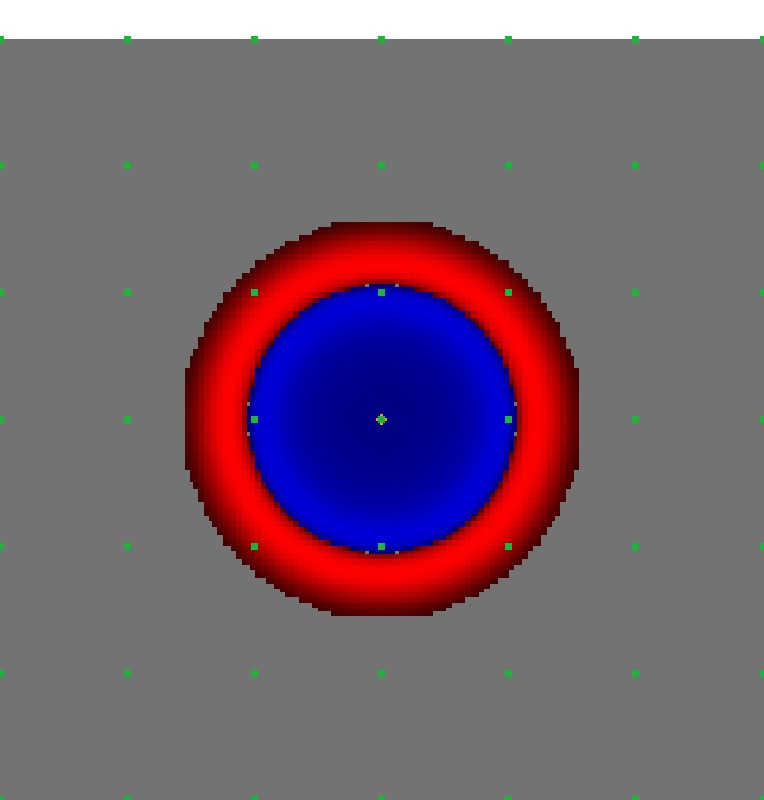

In [30]:
# Check your station configuration and source location
Image("OUTPUT_FILES/forward_image000001200.jpg")

[2022-10-04 00:04:53] - pysep - INFO: starting record section plotter
[2022-10-04 00:04:53] - pysep - INFO: Reading 49 synthetics from: OUTPUT_FILES
[2022-10-04 00:04:54] - pysep - INFO: checking parameter acceptability
[2022-10-04 00:04:54] - pysep - INFO: getting source-receiver stats
[2022-10-04 00:04:54] - pysep - INFO: calculating source-receiver distance and (back)azimuths
[2022-10-04 00:04:54] - pysep - INFO: preprocessing 49 `st` waveforms
[2022-10-04 00:04:54] - pysep - INFO: no filtering applied
[2022-10-04 00:04:54] - pysep - INFO: determining sort order with parameter: distance
[2022-10-04 00:04:54] - pysep - INFO: determining if any stations/channels should be skipped
[2022-10-04 00:04:54] - pysep - INFO: criteria check will remove 0/49 traces
[2022-10-04 00:04:54] - pysep - INFO: determining y-axis positioning for sort: distance
[2022-10-04 00:04:54] - pysep - INFO: determining amplitude scaling with: global_norm
[2022-10-04 00:04:54] - pysep - INFO: plotting record secti

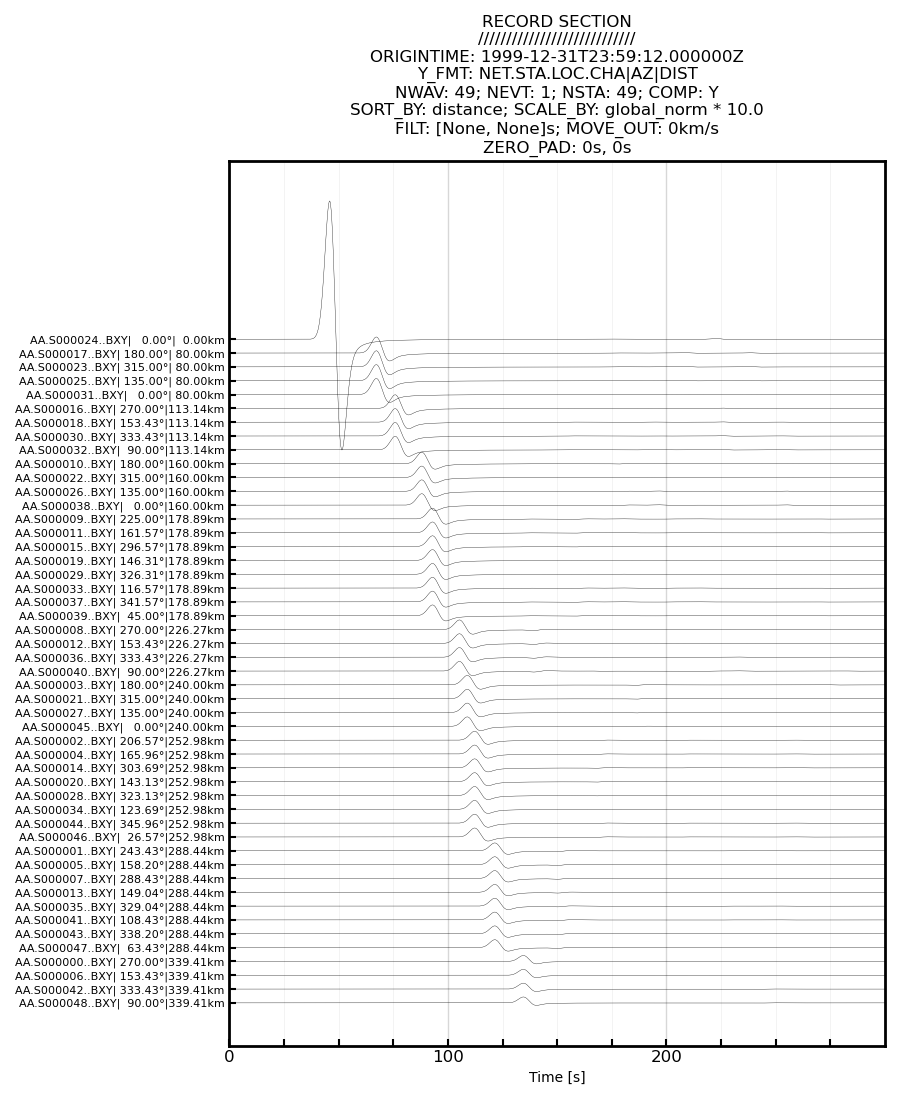

In [31]:
# Use RecSec to plot synthetics
! recsec --syn_path "OUTPUT_FILES" --cmtsolution 'DATA/SOURCE' --stations 'DATA/STATIONS' \
    --scale_by global_norm --amplitude_scale_factor 10 --components Y --cartesian -L INFO --overwrite

Image("record_section.png")

-----------
## 5) Optional: Automating Forward Simulations with SeisFlows

- `SeisFlows` is an automated workflow tool which takes care of all the tasks required to run SPECFEM   
- SeisFlows employs various preprocessing and optimization methods for seismic inversions (to be seen in Day 2 & 3)  
- We can automate forward simulations for multiple events in the Example we just ran  
- SeisFlows Example \#3 runs a automated en-masse forward simulations through a checkerboard model  

In [32]:
# Make sure were running in a clean working directory
! rm -r /home/scoped/work/day_1/sfexample
! mkdir -p /home/scoped/work/day_1/sfexample
%cd /home/scoped/work/day_1/sfexample

# The `example` command will setup and run our forward simulations
! seisflows examples run 3 -r  /home/scoped/specfem2d/ --with_mpi --nproc 1

rm: cannot remove '/home/scoped/work/day_1/sfexample': No such file or directory
/home/scoped/work/day_1/sfexample

                                    @@@@@@@@@@                        
                               .@@@@.    .%&(  %@.          
                            @@@@   @@@@   &@@@@@@ ,%@       
                         @@@@   @@@,  /@@              @    
                        @@@   @@@@   @@@              @     
                      @@@@   @@@@   @@@                @  @ 
                      @@@   @@@@   ,@@@                @ @  
                     @@@@   @@@@    @@@@              @@ @ @
                     @@@@   @@@@@    @@@@@          @@@ @@ @
                     @@@@    @@@@@     @@@@@@@@@@@@@@  @@  @
                      @@@@    @@@@@@        @@@&     @@@  @ 
                      @@@@@     @@@@@@@@         %@@@@#  @@ 
                        @@@@#      @@@@@@@@@@@@@@@@@   @@   
                         &@@@@@          @@@@(       @@&    
                    

You will know the example has finished when you are met with the following log message  

```
================================================================================
EXAMPLE COMPLETED SUCCESFULLY
================================================================================
```

#### Understanding SeisFlows outputs

- The example problem ran 10 simulations for 10 different sources (SOURCE_001 -> SOURCE_010)
- It used a checkerboard model (to be shown tomorrow, Day 2)  
- Each simulation output synthetic seismograms related to 25 station locations (Stations 1 -> 25)  
- Each Solver directory is itself a small SPECFEM working directory  
- SeisFlows stores its results in an `output/` directory  
- In the example, we have told SeisFlows to export synthetic waveforms generated by the solver  

In [33]:
# Each Solver directory is a SPECFEM working directory
! ls scratch/solver
! echo
! ls scratch/solver/001

001  002  003  004  005  006  007  008	009  010  mainsolver

bin  DATA  fwd_mesher.log  fwd_solver.log  OUTPUT_FILES  traces


Figure(707.107x707.107)


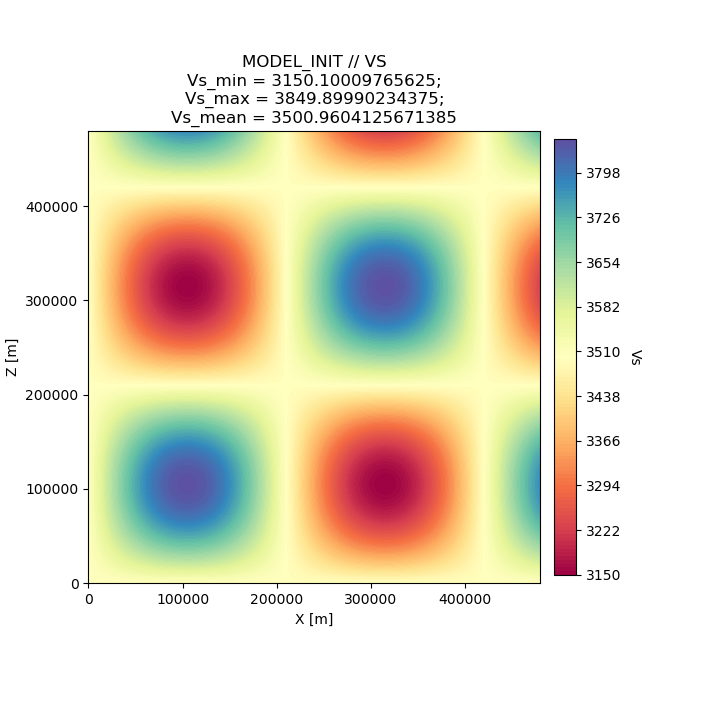

In [34]:
# We ran simulations through a checkerboard which we will explore tomorrow  
! seisflows plot2d MODEL_INIT vs --savefig m_init_vs.png
Image("m_init_vs.png")

In [35]:
# Each solver exported its synthetics to the output/ directory
! ls output/solver
! echo
!ls output/solver/001/syn

001  002  003  004  005  006  007  008	009  010

AA.S000000.BXY.semd  AA.S000009.BXY.semd  AA.S000018.BXY.semd
AA.S000001.BXY.semd  AA.S000010.BXY.semd  AA.S000019.BXY.semd
AA.S000002.BXY.semd  AA.S000011.BXY.semd  AA.S000020.BXY.semd
AA.S000003.BXY.semd  AA.S000012.BXY.semd  AA.S000021.BXY.semd
AA.S000004.BXY.semd  AA.S000013.BXY.semd  AA.S000022.BXY.semd
AA.S000005.BXY.semd  AA.S000014.BXY.semd  AA.S000023.BXY.semd
AA.S000006.BXY.semd  AA.S000015.BXY.semd  AA.S000024.BXY.semd
AA.S000007.BXY.semd  AA.S000016.BXY.semd
AA.S000008.BXY.semd  AA.S000017.BXY.semd


[2022-10-04 00:10:41] - pysep - INFO: starting record section plotter
[2022-10-04 00:10:41] - pysep - INFO: Reading 25 synthetics from: output/solver/001/syn
[2022-10-04 00:10:41] - pysep - DEBUG: output/solver/001/syn/AA.S000000.BXY.semd
[2022-10-04 00:10:41] - pysep - DEBUG: output/solver/001/syn/AA.S000001.BXY.semd
[2022-10-04 00:10:41] - pysep - DEBUG: output/solver/001/syn/AA.S000002.BXY.semd
[2022-10-04 00:10:41] - pysep - DEBUG: output/solver/001/syn/AA.S000003.BXY.semd
[2022-10-04 00:10:41] - pysep - DEBUG: output/solver/001/syn/AA.S000004.BXY.semd
[2022-10-04 00:10:41] - pysep - DEBUG: output/solver/001/syn/AA.S000005.BXY.semd
[2022-10-04 00:10:41] - pysep - DEBUG: output/solver/001/syn/AA.S000006.BXY.semd
[2022-10-04 00:10:41] - pysep - DEBUG: output/solver/001/syn/AA.S000007.BXY.semd
[2022-10-04 00:10:41] - pysep - DEBUG: output/solver/001/syn/AA.S000008.BXY.semd
[2022-10-04 00:10:41] - pysep - DEBUG: output/solver/001/syn/AA.S000009.BXY.semd
[2022-10-04 00:10:41] - pysep - 

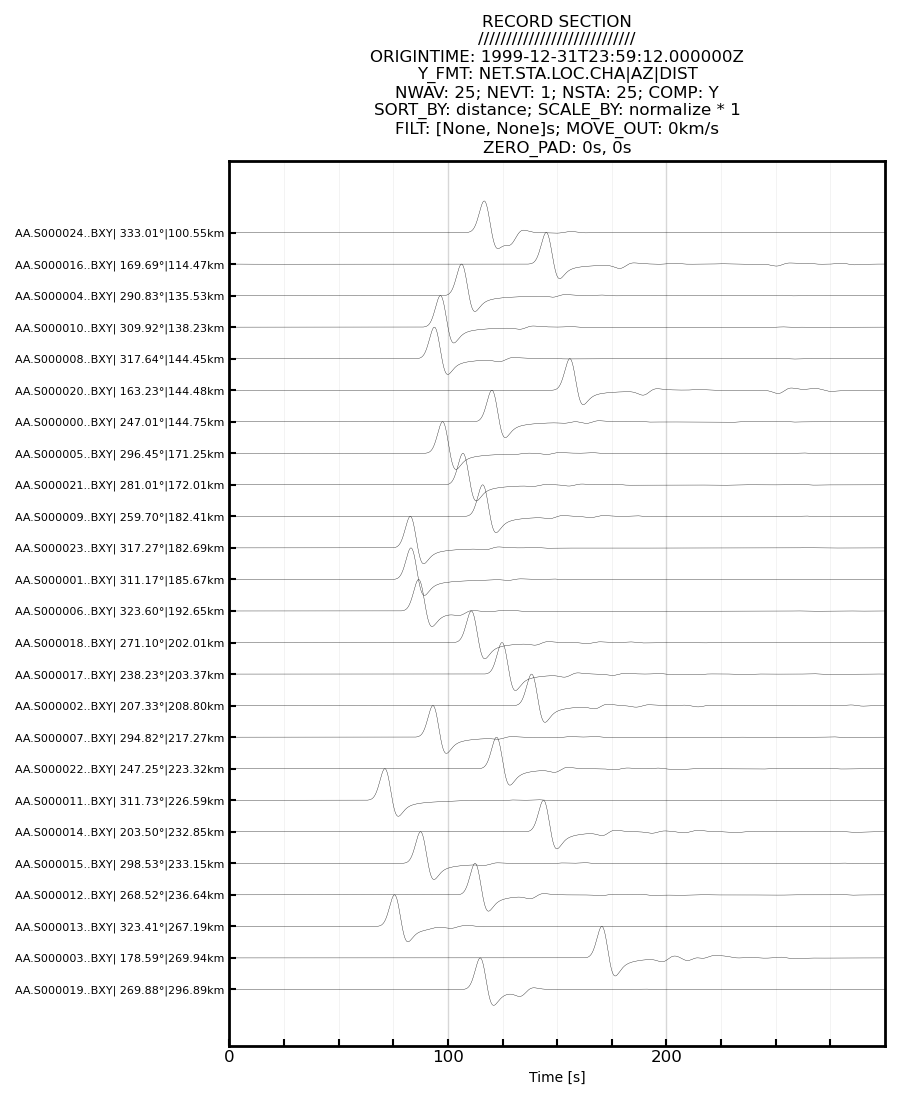

In [36]:
# We can plot synthetics for a single station using RecSec
! recsec --syn_path "output/solver/001/syn" --cmtsolution 'specfem2d_workdir/DATA/SOURCE_001' --stations 'specfem2d_workdir/DATA/STATIONS' --components Y --cartesian --save "s01_recsec.png"
Image("s01_recsec.png")